# Homework 1 helper functions

This notebook contains a range of helper functions that will be useful in completing homework 1.  Read through the examples carefully - and afterwards either throw them into a simple library, or copy and paste relevant chunks for re-use.

In [1]:
# import autograd wrapped numpy
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

# A simple gradient descent algo

Below you will find a simple gradient descent implementation.  It uses  three functions from the original autograd library (introduced in Homework 0) - including a [flattening function](https://nbviewer.jupyter.org/github/jermwatt/autograd_tutorials/blob/b775b089460e2204a5d37dcaada5e0842ca3f0de/flattening_functions.ipynb) strictly used for convenience that flattens (duh) a function for an easier to write [gradient descent function](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_6_Descent.html).

The inputs of this function are as follows:

- `g` : an input function to minimize
- `w_init` : an initialization for the optimization process
- `alpha` : steplength / learning rate
- `max_its` : a maximum number of iterations to run
- `verbose` : set to 'True" to print the result of each step of gradient descent

And the outputs:

- `w_hist` : a history of each set of weights from the a run of gradient descent
- `train_hist` : a corresponding cost function history

In [2]:
import autograd.numpy as np
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func

# gradient descent
def gradient_descent(g,w_init,alpha,max_its,verbose): 
    # flatten the input function
    g_flat, unflatten, w = flatten_func(g, w_init)
    
    # compute gradient of flattened input function
    # when evaluated this returns both the evaluation of the gradient and the original function
    grad = value_and_grad(g_flat)
    cost_eval,grad_eval = grad(w)
    grad_eval.shape = np.shape(w)

    # record history
    w_hist = [unflatten(w)]
    train_hist = [cost_eval]
        
    # gradient descent loop
    for k in range(max_its): 
        # take descent step with momentum
        w = w - alpha*grad_eval
        
        # plug in updated w into func and gradient
        cost_eval,grad_eval = grad(w)
        grad_eval.shape = np.shape(w)
                
        # store updates
        w_hist.append(unflatten(w))
        train_hist.append(cost_eval)

        # print update
        if verbose == True:
            print ('step ' + str(k+1) + ' complete, train cost = ' + str(np.round(train_hist[-1],4)[0]))

    # print update and return
    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')
    return w_hist,train_hist

A simple demonstration using a toy function - a simple $10$ dimensional quadratic centered at the origin.

In [3]:
# a simple toy function
g = lambda w: np.dot(w.T,w)

# run gradient descent algo above to minimize toy function
w_init = 0.1*np.random.randn(10,1)
max_its = 100
alpha = 10**(-1)
w_hist,train_hist = gradient_descent(g,w_init,alpha,max_its,verbose=True)

step 1 complete, train cost = 0.0621
step 2 complete, train cost = 0.0397
step 3 complete, train cost = 0.0254
step 4 complete, train cost = 0.0163
step 5 complete, train cost = 0.0104
step 6 complete, train cost = 0.0067
step 7 complete, train cost = 0.0043
step 8 complete, train cost = 0.0027
step 9 complete, train cost = 0.0017
step 10 complete, train cost = 0.0011
step 11 complete, train cost = 0.0007
step 12 complete, train cost = 0.0005
step 13 complete, train cost = 0.0003
step 14 complete, train cost = 0.0002
step 15 complete, train cost = 0.0001
step 16 complete, train cost = 0.0001
step 17 complete, train cost = 0.0
step 18 complete, train cost = 0.0
step 19 complete, train cost = 0.0
step 20 complete, train cost = 0.0
step 21 complete, train cost = 0.0
step 22 complete, train cost = 0.0
step 23 complete, train cost = 0.0
step 24 complete, train cost = 0.0
step 25 complete, train cost = 0.0
step 26 complete, train cost = 0.0
step 27 complete, train cost = 0.0
step 28 complete

Print out the best weights from this run.  Note the global minimum here is at the origin where the cost function takes on zero value.  We get quite close.

In [4]:
### determine and show the best set of weights / cost evaluation from this run
# index of the minimum cost value attained
ind = np.argmin(train_hist)

# corresponding weights and cost evaluation
w_best = w_hist[ind]
g_best = train_hist[ind]
print('======== best set of weights ========')
print(w_best)
print('======== best associated cost val ========')
print(g_best)

======== best set of weights ========
[[ 2.82425092e-11]
 [-6.46459484e-12]
 [-1.77345160e-11]
 [-3.25114065e-11]
 [-4.52212300e-12]
 [ 1.71439318e-11]
 [-1.77606838e-11]
 [ 5.08731197e-12]
 [-2.00687647e-11]
 [-2.75214049e-11]]
======== best associated cost val ========
[4.02680459e-21]


Here is a small function to print out a picture of the cost function history.

In [5]:
import matplotlib.pyplot as plt
def plot_cost_function_history(cost_history):
    figure = plt.figure(figsize = (10,3))
    plt.plot(cost_history)
    plt.xlabel('iteration')
    plt.ylabel('cost value',rotation = 90)
    plt.show()

<IPython.core.display.Javascript object>


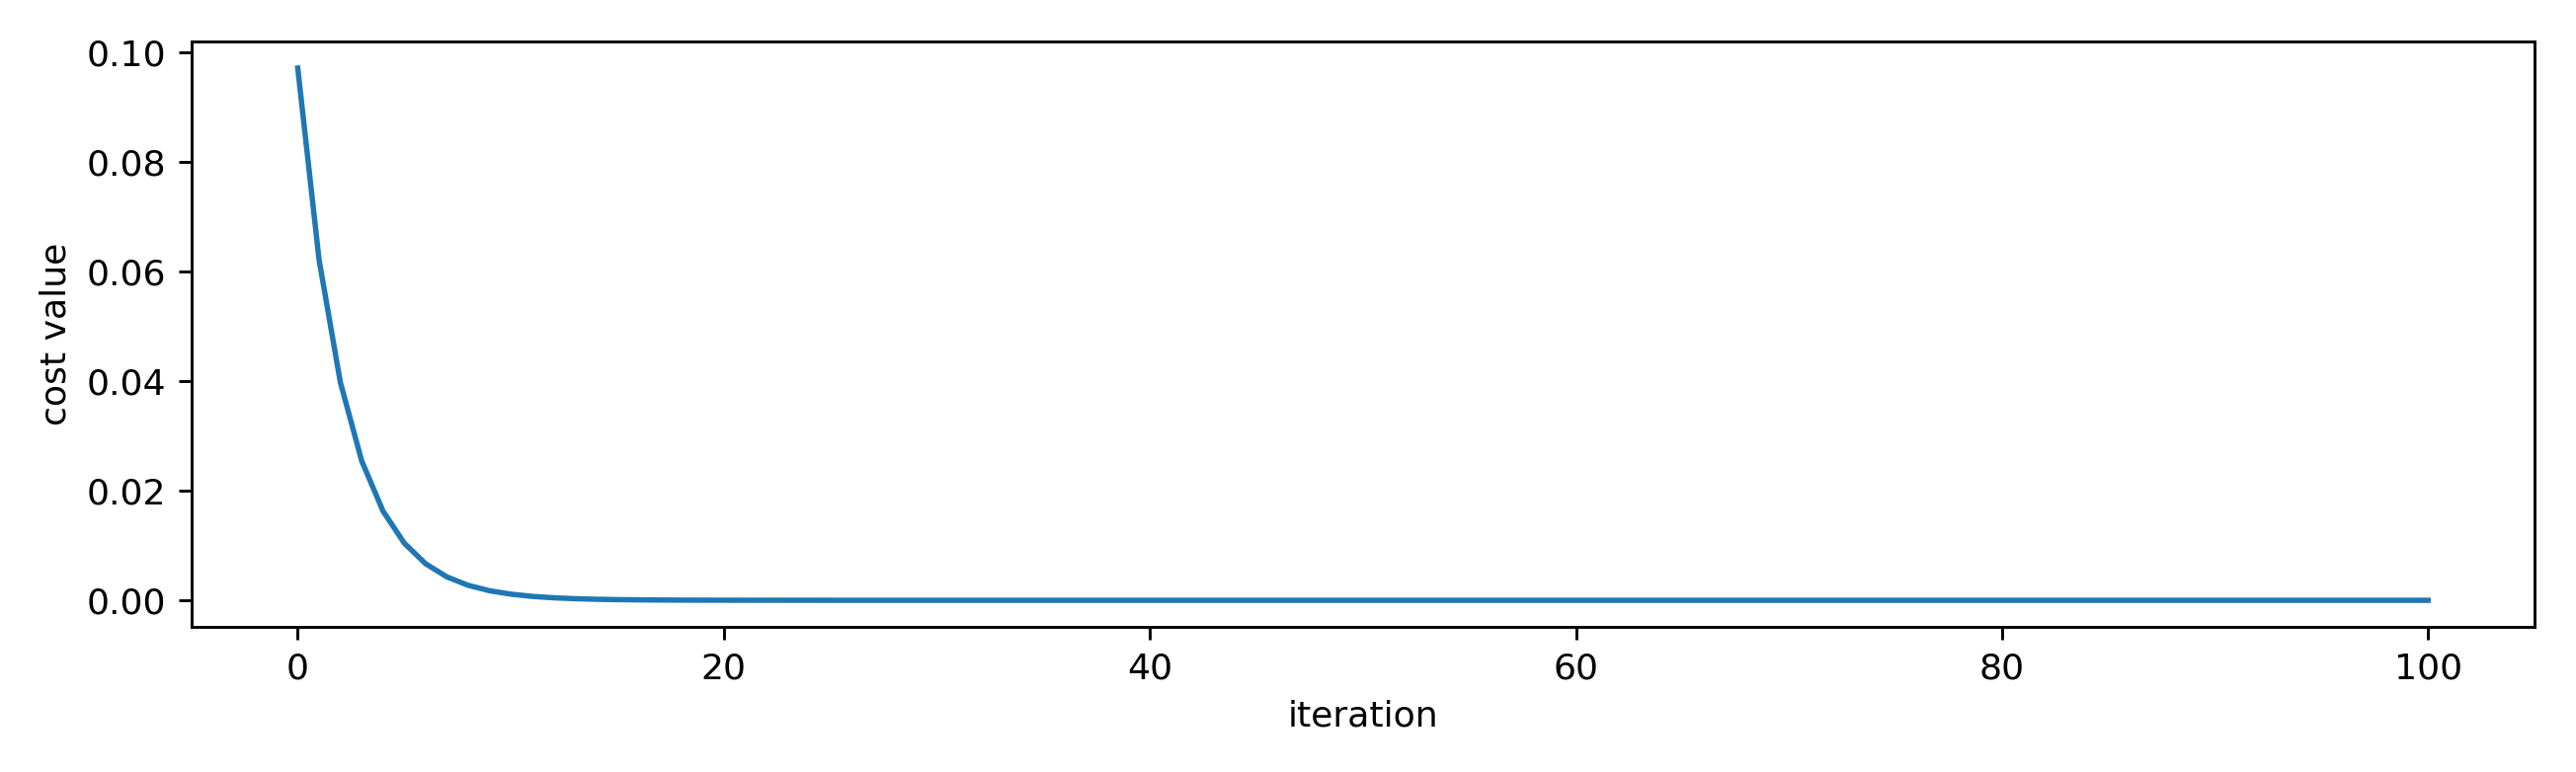

In [6]:
# print out that cost function history plot
plot_cost_function_history(train_hist)

# Standard normalization function 

Standard normalization is a common technique for pre-processing input data in machine learning in order to drastically improve (particularly) first order optimization - see [our set of notes on the subject for further detail](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html).  This involves

- mean centereing - along each input dimension - the input of a machine learning dataset

- re-scaling each input dimension by its standard deviation


Below is a standard normalization function.  The input to this function is

- `x` : an N x P input data matrix, here N is the input dimension of each point and P is the number of points in the dataset

and corresponding output

- `normalizer` : a function for normalizing data according to the statistics of `x`

- `inverse_normalizer` : a function for reversing this normalization 

In [7]:
# standard normalization function 
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

Lets put it to work.  Below we load in a simple dataset and visualize it.

In [8]:
# load in a dataset
x = np.loadtxt('datasets/2d_span_data.csv',delimiter=',')

# visualize this dataset
import matplotlib.pyplot as plt
def scatter_dataset(data,show_axes):
    figure = plt.figure(figsize = (5,5))
    plt.scatter(data[0,:],data[1,:],c='b',edgecolor='w')
    if show_axes==True:
        plt.axhline(y=0,c='k',zorder=0)
        plt.axvline(x=0,c='k',zorder=0)
        plt.axis('equal')
    plt.show()

<IPython.core.display.Javascript object>


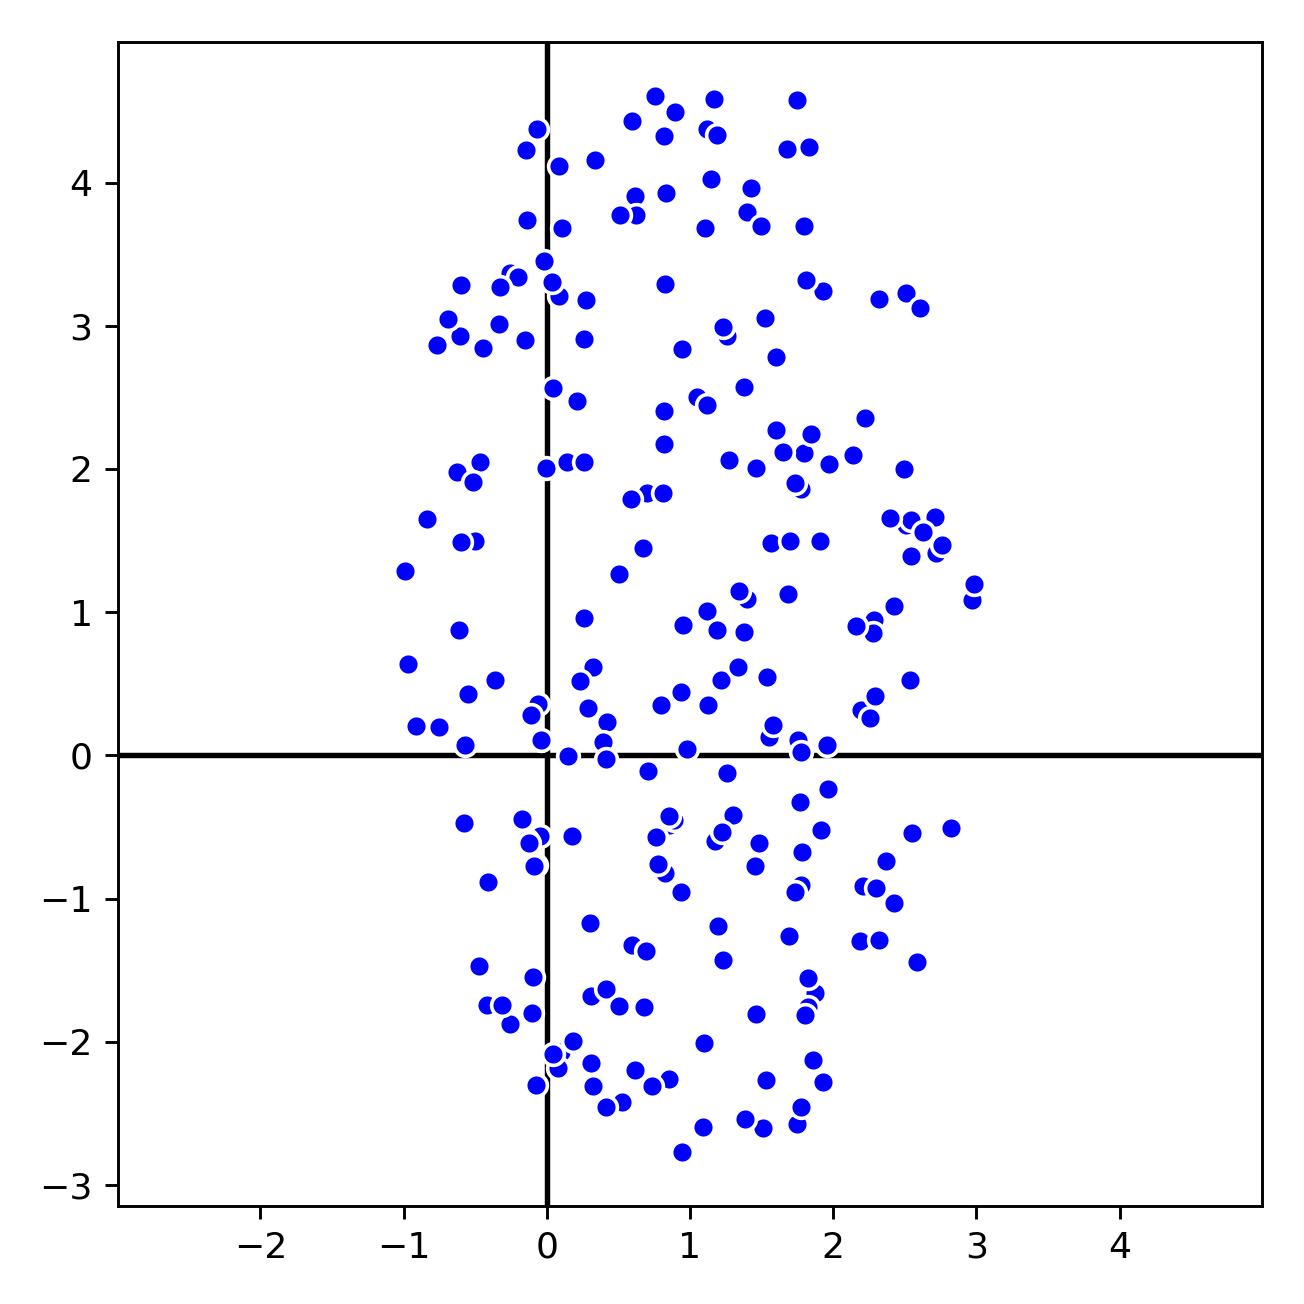

In [9]:
# visualize this dataset
scatter_dataset(x,True)

Now lets standard normalize this dataset using the functionality above.

<IPython.core.display.Javascript object>


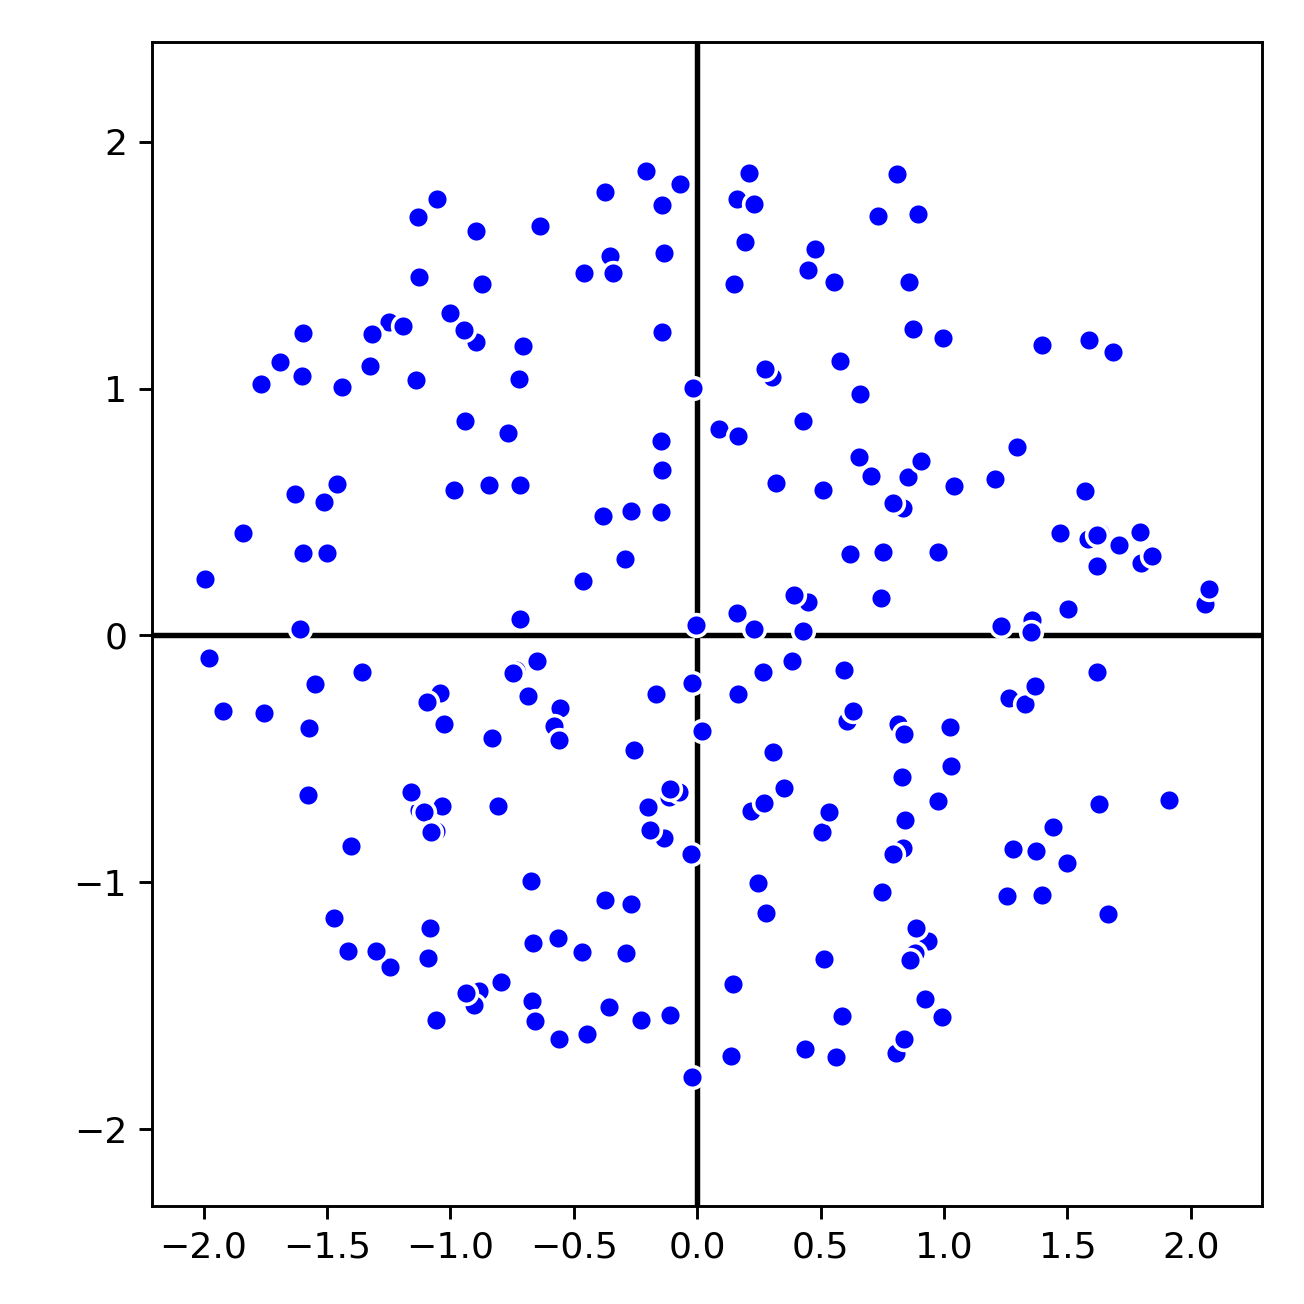

In [10]:
# create normalizer and inverse_normalizer based on the stats of x
normalizer,inverse_normalizer = standard_normalizer(x)

# use the corresponding normalizer to normalize x
x_normalized = normalizer(x)

# scatter the standard normalized data
scatter_dataset(x_normalized,True)

# A least squares function + putting it all together

Lets combine the gradient descent optimizer and standard normalizer above to perform [linear regression](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html).  

First up - an implementation of a linear model and Least Squares cost

In [11]:
# compute linear combination of input points
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

# an implementation of the least squares cost function for linear regression
def least_squares(w,x,y):    
    # compute the least squares cost
    cost = np.sum((model(x,w) - y)**2)
    return cost/y.size

Lets load in and scatter a very linear dataset.

<IPython.core.display.Javascript object>


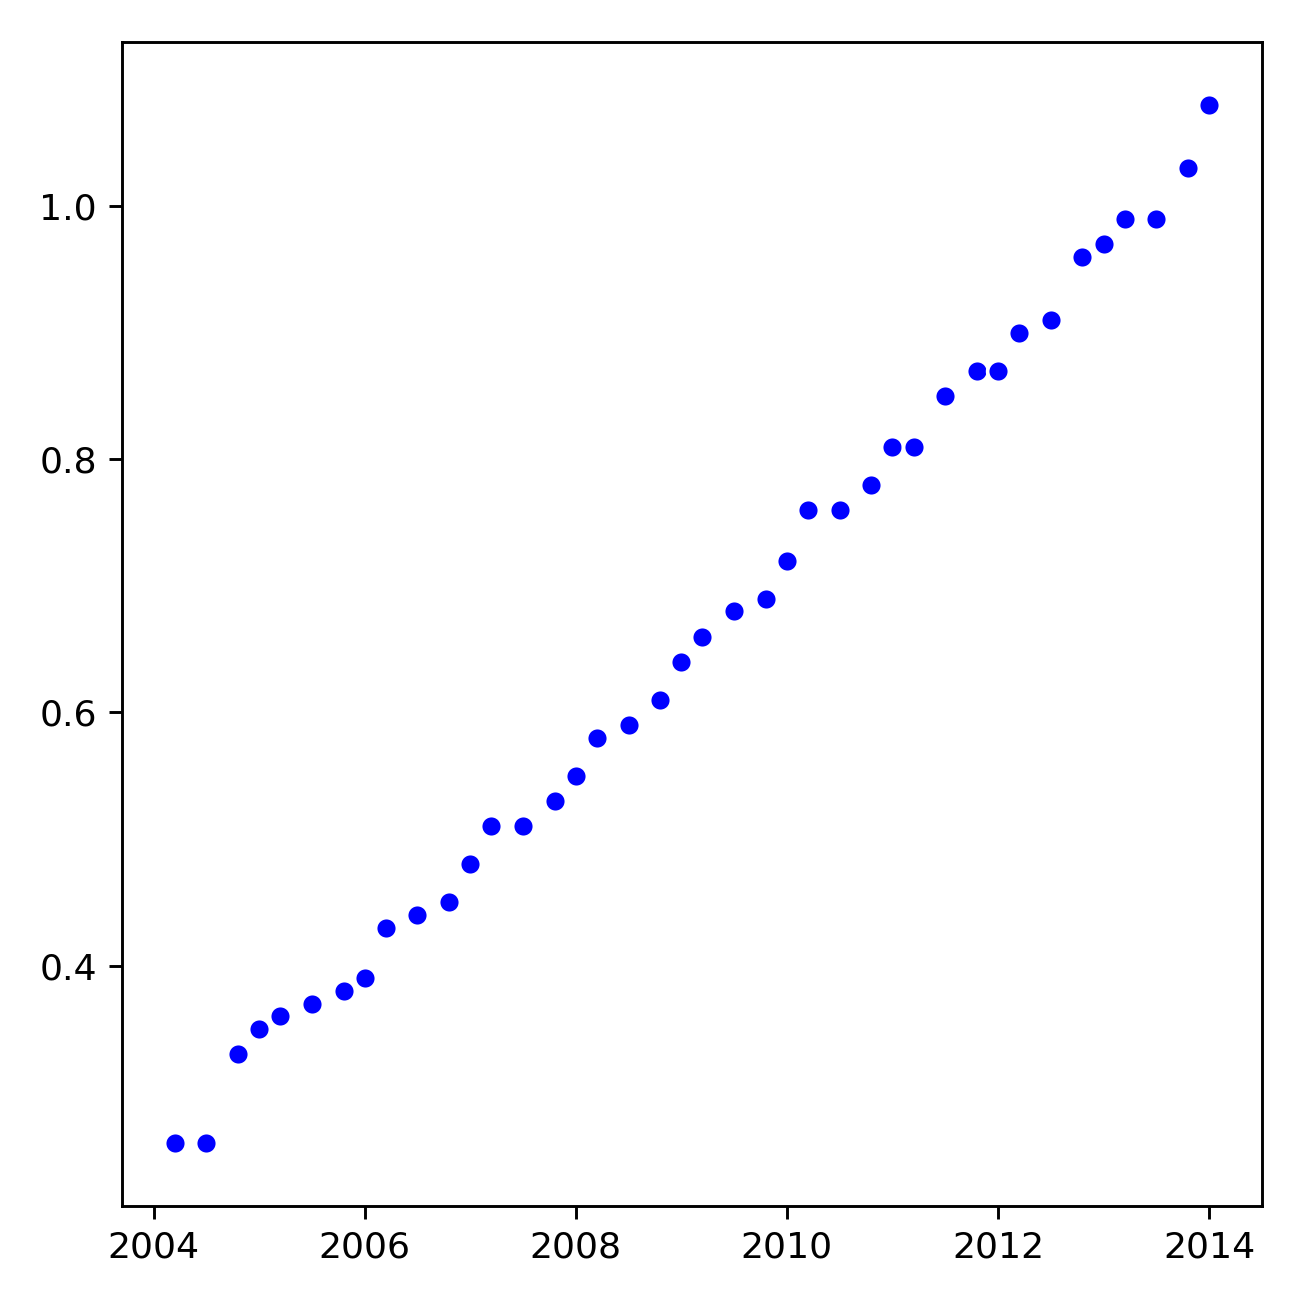

In [12]:
# load in dataset
data = np.loadtxt('datasets/student_debt.csv',delimiter=',')
x_data = data[0,:][np.newaxis,:]  # input data
y_data = data[1,:][np.newaxis,:]  # corresponding output 

# scatter data
scatter_dataset(data,False)

Notice how HUGE the input data is here when compared to the output?   That will make performing linear regression via a first order optimizer VERY challenging, UNLESS we standard normalize the input first (see [our notes](https://jermwatt.github.io/machine_learning_refined/notes/9_Feature_engineer_select/9_3_Scaling.html)).

In [13]:
# create normalizer and inverse_normalizer based on the stats of x
normalizer,inverse_normalizer = standard_normalizer(x_data)

# use the corresponding normalizer to normalize x
x_normalized = normalizer(x_data)

Now lets lock in an instance of the Least Squares function with our input/output data locked in.  Then perform gradient descent to minimize the cost.

In [14]:
# make an instance of the Least Squares cost with this data locked in
g = lambda w,x=x_normalized,y=y_data: least_squares(w,x,y)

The function `g` above is now a copy of the Least Squares cost that is only a function over its weights `w`, since both the input/output data are now fixed.

<IPython.core.display.Javascript object>


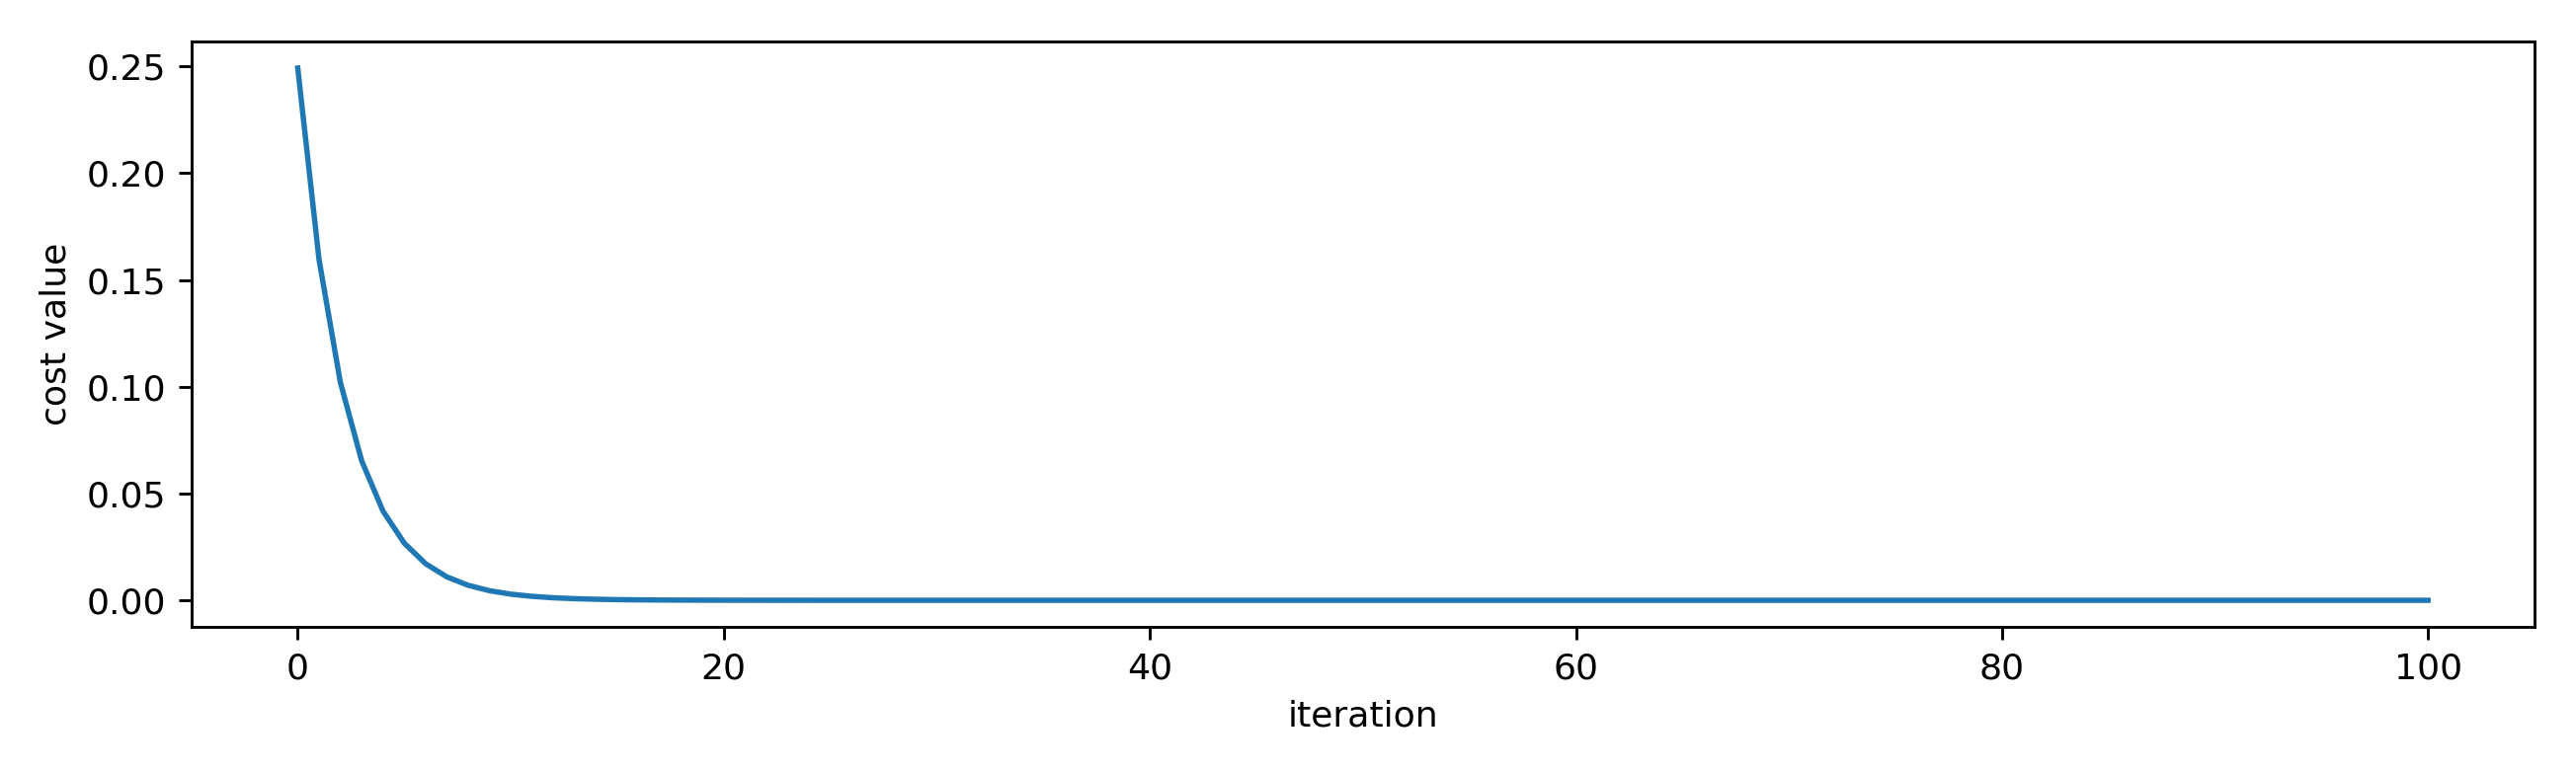

In [15]:
# run gradient descent algo above to minimize toy function
w_init = 0.1*np.random.randn(2,1)
max_its = 100
alpha = 10**(-1)
w_hist,train_hist = gradient_descent(g,w_init,alpha,max_its,verbose=False)

# print out that cost function history plot
plot_cost_function_history(train_hist)

Finally - just for kicks - lets plot our fully trained model on the data.

First we get the best set of weights from our run of gradient descent, and produce a corresponding `trained_model` with these weights locked in.

In [16]:
# index of the minimum cost value attained
ind = np.argmin(train_hist)

# corresponding weights and cost evaluation
w_best = w_hist[ind]
g_best = train_hist[ind]

# produce fully trained model - with best parameters locked in
trained_model = lambda x,w=w_best: model(normalizer(x),w)

Now lets get plotting.

<IPython.core.display.Javascript object>


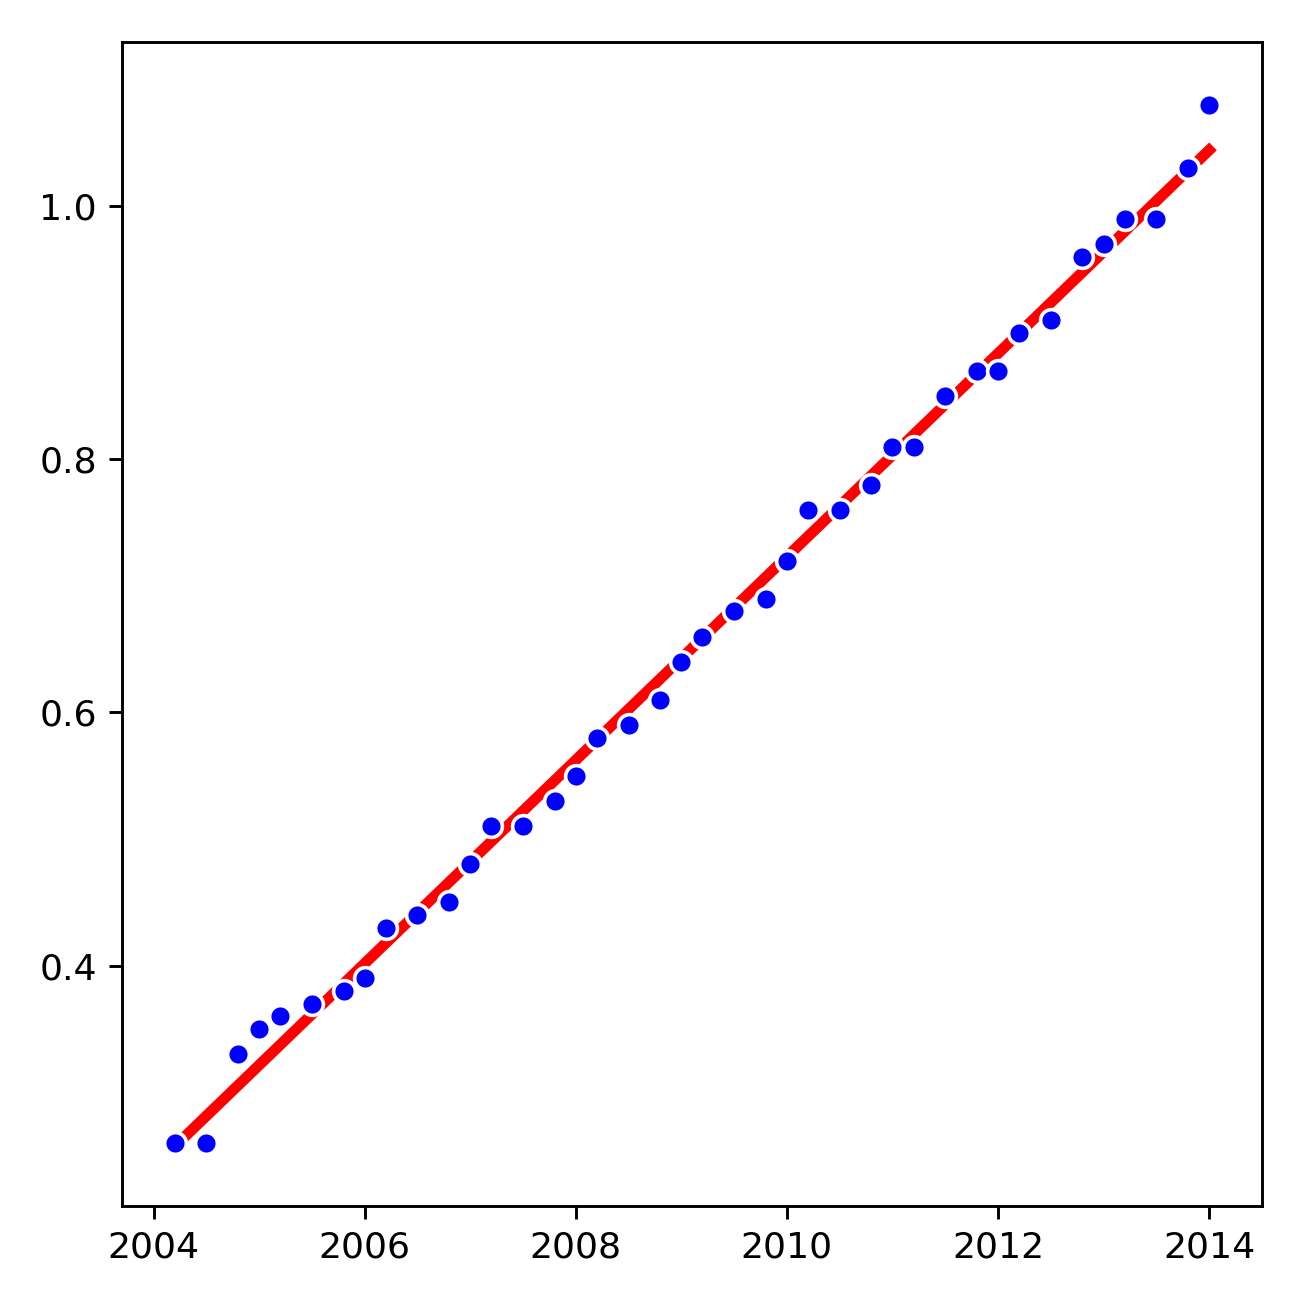

In [17]:
# visualize simple regression dataset and the result of trained model
import matplotlib.pyplot as plt
def plot_data_and_model(data,trained_model):
    # produce figure, plot data
    figure = plt.figure(figsize = (5,5))
    plt.scatter(data[0,:],data[1,:],c='b',edgecolor='w')
    
    # show fit from trained model
    s = np.linspace(min(data[0,:]),max(data[0,:]))[np.newaxis,:]
    t = trained_model(s)
    plt.plot(s.flatten(),t.flatten(),color='r',linewidth=3,zorder=0)
    plt.show()
    
plot_data_and_model(data,trained_model)

Looks good!

# (Optional) Saving a trained model to file

Lets save our trained model to file using [`dill`](https://pypi.org/project/dill/).  You can install this module on your machine by typing the following command at your terminal

                    pip install dill

First we save our trained model to `trained_model.pkl` as shown below.

In [18]:
import dill as pickle
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(trained_model, file)

Then load it as `loaded_model` below.

In [19]:
with open('trained_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

Now we can test it out by plugging in our original training data

In [20]:
loaded_model(x_data)

array([[0.25715224, 0.28124957, 0.30534689, 0.32141178, 0.33747666,
        0.36157399, 0.38567131, 0.4017362 , 0.41780108, 0.4418984 ,
        0.46599573, 0.48206061, 0.4981255 , 0.52222282, 0.54632015,
        0.56238503, 0.57844991, 0.60254724, 0.62664456, 0.64270945,
        0.65877433, 0.68287166, 0.70696898, 0.72303386, 0.73909875,
        0.76319607, 0.7872934 , 0.80335828, 0.81942317, 0.84352049,
        0.86761782, 0.8836827 , 0.89974758, 0.92384491, 0.94794223,
        0.96400712, 0.980072  , 1.00416933, 1.02826665, 1.04433153]])